In [29]:
#imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LogisticRegression 

%matplotlib inline

# Column names from the word document "Network Anamoly Detection" for the dataset
column_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

dataset = pd.read_csv("../Data/Train.txt", names=column_names)
dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


### Cleaning and preparing the dataset

In [2]:
# Removing rows with no values in them
print("shape pre-dropna:", dataset.shape)
dataset.dropna(inplace=True)
print("shape post-dropna:", dataset.shape)

shape pre-dropna: (125973, 43)
shape post-dropna: (125973, 43)


In [3]:
# Giving the categories in the nominal features a separate column each with binarY/boolean values
temp = pd.get_dummies(dataset[['protocol_type', 'service', 'flag']]).astype('int')
# Replaces three features with eighty-four features boolean
print(temp.shape)

# Getting the attack classes from the dataset
attack_classes = dataset.attack
attack_classes_dummy = pd.get_dummies(dataset['attack']).astype('int')
# print(attack_classes.replace(to_replace="normal", value=0).replace)

# Normal traffic is classified as 0, while malicious traffic is classed as 1.
def mapping(val):
    if val == "normal":
        return 0
    else:
        return 1
attack_classes_binary = attack_classes.apply(mapping)
# print(attack_classes_binary)

# Dropping the independent variable 'attack' and the columns 'protocol_type', 'service', and 'flag' 
temporary_dataset = dataset.drop(['attack', 'protocol_type', 'service', 'flag'], axis=1).astype('float64')

new_dataset = pd.concat([temporary_dataset, temp], axis=1)

new_dataset.head()



(125973, 84)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,232.0,8153.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,199.0,420.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


### Correlation between features

hot and is_guest_login are highly correlated (0.8602881047178516)
num_compromised and num_root are highly correlated (0.9988334525784719)
num_root and num_compromised are highly correlated (0.9988334525784719)
is_guest_login and hot are highly correlated (0.8602881047178516)
is_guest_login and service_ftp are highly correlated (0.8200690977851709)
serror_rate and srv_serror_rate are highly correlated (0.9932892425370415)
serror_rate and dst_host_serror_rate are highly correlated (0.9793730829843228)
serror_rate and dst_host_srv_serror_rate are highly correlated (0.9811389586179857)
serror_rate and flag_S0 are highly correlated (0.9791740914923958)
srv_serror_rate and serror_rate are highly correlated (0.9932892425370415)
srv_serror_rate and dst_host_serror_rate are highly correlated (0.9775960119654394)
srv_serror_rate and dst_host_srv_serror_rate are highly correlated (0.9862517164930875)
srv_serror_rate and flag_S0 are highly correlated (0.9826599622600537)
rerror_rate and srv_rerror

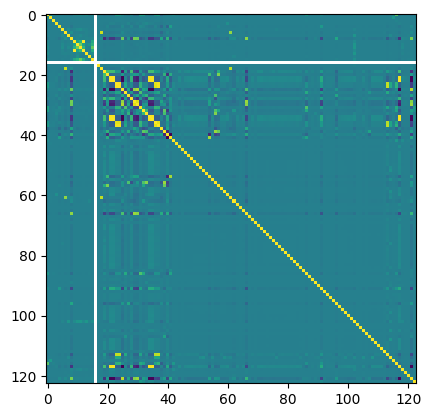

[[1.0, 0.07073682819085414, 0.03487779833437003, -0.0015532805525947443, -0.009865808515815139, 0.003829897181915918, 0.000705120566211187, 0.009528249936349882, -0.06421767647301116, 0.042679474817442095, 0.052790950792928525, 0.08718341292134439, 0.045519157361409816, 0.09911569750163096, -0.0015934673468352128, 0.07041992093460996, nan, -0.00025761943672739616, 0.0004402248819930365, -0.07904231889655419, -0.03947023790265667, -0.06987295957015192, -0.06951028293813129, 0.2006819844142431, 0.19996108167067075, 0.07468058598343401, -0.01373757895926031, -0.04015809532609311, 0.05057003428877992, -0.109775561199984, -0.11600495557790014, 0.2541951745852428, 0.2287373765622746, -0.026669376728929953, -0.06494796244229974, -0.06436051447487312, 0.1738152898998144, 0.19902360421159065, -0.15631061303783145, -0.029263345542364316, -0.004642982519098148, 0.027974374377361635, 0.09319418730832142, 0.0037412564778459014, -0.007744632866980154, -0.0004392939757158932, -0.008205440388428653, -

In [4]:
result = []
for columnx in new_dataset.columns:
    resulting_row = []
    for columny in new_dataset.columns:
        correlation = new_dataset[columnx].corr(new_dataset[columny])
        if (columnx != columny) and (correlation > 0.9):
            print(f"{columnx} and {columny} are highly correlated ({correlation})")
        resulting_row.append(correlation)
    result.append(resulting_row)

plt.imshow(result)
plt.show()

print(result)

### Leave one out - cross validation

In [18]:
def loocv(dataset, feature_set, attack_classes, model):
    result = []
    print(dataset.iloc[0][list(feature_set)])
    for index, attack_class in enumerate(attack_classes):
        calc = (attack_class - model.predict(dataset.iloc[index][list(feature_set)]))**2
        result.append(calc)
    return np.sum(result)/len(result)

### K-fold cross validation

In [6]:
def kfcv(dataset, feature_set, attack_classes, model, k):
    pass

### Finding the best model and its feature set

In [28]:
# Function for finding the best model
def best_logistical_regression_model_with_a_features_set(dataset, attack_classes, feature_set):
    # model = sm.OLS(attack_classes, dataset[list(feature_set)])
    # model = sm.Logit(attack_classes, dataset[list(feature_set)])
    # logistical_regression = model.fit(maxiter=130)
    
    logistical_regression = LogisticRegression()
    logistical_regression.fit(dataset[list(feature_set)], attack_classes)
    
        # ResidualSumOfSquares = ((logistical_regression.predict(dataset[list(feature_set)]) - attack_classes)**2).sum()
        # return {'model': logistical_regression, 'RSS': ResidualSumOfSquares}
    kfold = KFold(n_splits=10)
    cv_err = []
    # for i, d in enumerate(range(10)):
    #     X = np.power.outer()
    cv = cross_validate(logistical_regression, cv=kfold)
    # print(res)
    return {'model': logistical_regression, 'error': res, 'feature_set': feature_set} #loocv(dataset, feature_set, attack_classes, logistical_regression) # ask what type of way your deteming it? something about forward  analysis
    

def best_logistical_regression_model_with_a_number_of_predictors(dataset, attack_classes, predictors):
    results = []
    for combination in itertools.combinations(dataset.columns, predictors):
        results.append(best_logistical_regression_model_with_a_features_set(dataset, attack_classes, combination))
    models = pd.DataFrame(results)
    
    print(models['error'])
    return models.loc[models['error'].argmin()]

def get_best_logistical_regression_model(dataset, attack_classes):
    results = []
    for predictors in len(dataset.columns):
        results.append(best_logistical_regression_model_with_a_number_of_predictors(dataset, attack_classes, predictors))
    best_models = pd.DataFrame(results)
    
    # indexes = np.asarray(best_models.keys())
    print(best_models.head())
    plt.plot(best_models.apply(lambda row: row[1].rsquared, axis=1))
    plt.title("Plot of the r squared value over the best models")
    plt.show()
    
    plt.plot(best_models.apply(lambda row: row[1].bic, axis=1))
    plt.title("Plot of the bic value over the best models")
    plt.show()
    
    plt.plot(best_models.apply(lambda row: row[1].aic, axis=1))
    plt.title("Plot of the aic value over the best models")
    plt.show()
    
    plt.plot(best_models.apply(lambda row: row[1].rsquared_adj, axis=1))
    plt.title("Plot of the adjusted r squared value over the best models")
    plt.show()

In [27]:
best_logistical_regression_model_with_a_number_of_predictors(new_dataset, attack_classes_binary, 1).summary()

0      KFold(n_splits=10, random_state=None, shuffle=...
1      KFold(n_splits=10, random_state=None, shuffle=...
2      KFold(n_splits=10, random_state=None, shuffle=...
3      KFold(n_splits=10, random_state=None, shuffle=...
4      KFold(n_splits=10, random_state=None, shuffle=...
                             ...                        
118    KFold(n_splits=10, random_state=None, shuffle=...
119    KFold(n_splits=10, random_state=None, shuffle=...
120    KFold(n_splits=10, random_state=None, shuffle=...
121    KFold(n_splits=10, random_state=None, shuffle=...
122    KFold(n_splits=10, random_state=None, shuffle=...
Name: error, Length: 123, dtype: object


TypeError: reduction operation 'argmin' not allowed for this dtype